In [3]:
import os
import nway
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from PIL import Image
from pynwb import NWBHDF5IO


In [4]:
dandiset_id = "000336"
dandi_filepath = "sub-1170622509/sub-1170622509_ses-1194683535-1194752574-_ophys.nwb"

authenticate = True
dandi_api_key = os.environ["dandi_api_key"]

In [5]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)

filename = dandi_filepath.split("/")[-1]
filepath = f"./{filename}"
file = my_dandiset.get_asset_by_path(dandi_filepath)

A newer version (0.51.0) of dandi/dandi-cli is available. You are using 0.46.3


In [6]:
# # this may take awhile, especially if the file to download is large
# file.download(filepath)

# print(f"Downloaded file to {filepath}")

In [7]:
data_dir = "../../../data/dendrite_coupling"
io = NWBHDF5IO(f"{data_dir}/sub-1168633075_ses-1193555033-1193675745-_ophys.nwb", mode="r", load_namespaces=True)
nwb1 = io.read()

io = NWBHDF5IO(f"{data_dir}/sub-1168633075_ses-1194555869-1194754129-_ophys.nwb", mode="r", load_namespaces=True)
nwb2 = io.read()

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [8]:
nwbs = [nwb1, nwb2]

### Generating Cell-Matching Input File

In [9]:
def make_roi_entries(roi_table):
    roi_entries = []
    for roi_idx in range(len(roi_table)):
        x = int(roi_table["x"][roi_idx])
        y = int(roi_table["y"][roi_idx])
        height = int(roi_table["height"][roi_idx])
        width = int(roi_table["width"][roi_idx])
        
        mask_subimage = roi_table["image_mask"][roi_idx][y:y+height,x:x+width]
        
        roi_entry = {
            "id": int(roi_table["id"][roi_idx]),
            "valid": bool(roi_table["valid_roi"][roi_idx]),
            "x": x,
            "y": y,
            "z": 1,
            "width": width,
            "height": height,
            # convert 2D array to 2D list of bools
            "mask_matrix": [[bool(elem) for elem in row] for row in mask_subimage]
        }
        roi_entries.append(roi_entry)
    return roi_entries

In [54]:
def normalize_to_16b(image_array):
#     mn = image_array.min()
#     mx = image_array.max()
#     mx -= mn
#     image_array = ((image_array - mn)/mx) * (2**8)
    image_array = image_array * 2**8
    return image_array.astype(np.uint16)

(array([9.50000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 7.62000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 9.03020e+04, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.38022e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.80330e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.98200e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        6.89000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.80000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 4.60000e+01, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.70000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+01, 0.00000e+00, 0.00

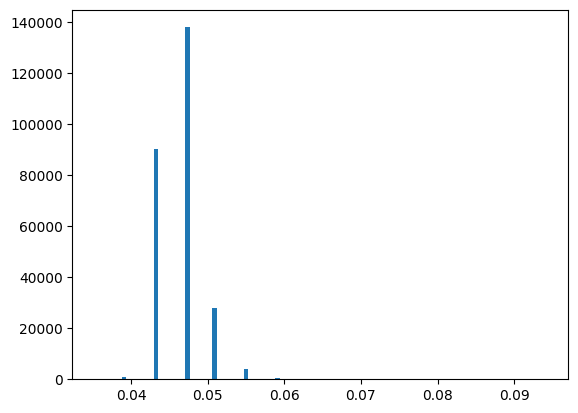

In [65]:
grayscale_image = np.array(nwb1.processing["ophys"]["images"]["average_image"])
# image_array = normalize_to_16b(np.array(grayscale_image))
# image_file = Image.fromarray(image_array)
# print(image_array)
# plt.imshow(image_file)

### Break

In [56]:
def nwb_to_experiment_json(nwb):
    # save image here
    grayscale_image = np.array(nwb.processing["ophys"]["images"]["average_image"])
    image_array = normalize_to_16b(np.array(grayscale_image))
    image_file = Image.fromarray(image_array)
    image_file = image_file.convert("L")
    image_file.save(f"./{nwb.identifier}_image.png")

    roi_table = nwb.processing["ophys"]["image_segmentation"]["cell_specimen_table"]
    
    experiment = {
        "id": nwb.identifier, 
        "ophys_average_intensity_projection_image": f"./{nwb.identifier}_image.png",
        "cell_rois": make_roi_entries(roi_table)
    }

    return experiment

In [57]:
input_exps = {
    "experiment_containers": {
        "ophys_experiments": []
    }
}

for nwb in nwbs:
    experiment = nwb_to_experiment_json(nwb)
    input_exps["experiment_containers"]["ophys_experiments"].append(experiment)

with open("input.json", "w") as f:
    json.dump(input_exps, f, indent=2)

In [43]:
!python -m nway.nway_matching --input_json input.json --output_json test_output/output.json --output_dir test_output

INFO:NwayMatching:NWAY_COMMIT_SHA None
INFO:NwayMatching:Nway matching version 0.6.0
INFO:PairwiseMatching:Matching 1193675745 to 1194754129
INFO:PairwiseMatching:Matching 1193675745 to 1194754129: best registration was ['Crop', 'CLAHE', 'PhaseCorrelate', 'ECC']
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\nway\utils.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  df = df.sort_index(0)
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\nway\utils.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  df = df.sort_index(1)
INFO:NwayMatching:registration success(1) or failure (0):
   0  1
0  1  1
1  1  1
id map{
  "0": 1193675745,
  "1": 1194754129
}
INFO:NwayMatching:Nway matching is done!
INFO:NwayMatching:Creating match summary plots
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-